In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("column_3C.dat", header=None, delim_whitespace=True)

# Assign column names
df.columns = [
    "pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle",
    "sacral_slope", "pelvic_radius", "degree_spondylolisthesis", "class"
]

# View structure
print("Shape:", df.shape)
print("\nClass Distribution:\n", df["class"].value_counts())
print("\nSample Data:\n", df.head())

Shape: (310, 7)

Class Distribution:
 class
SL    150
NO    100
DH     60
Name: count, dtype: int64

Sample Data:
    pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  degree_spondylolisthesis class  
0          98.67                     -0.25    DH  
1         114.41                      4.56    DH  
2         105.99                     -3.53    DH  
3         101.87                     11.21    DH  
4         108.17                      7.92    DH  


/var/folders/7r/m8v4tkn15jd4nfnjhb1n92280000gn/T/ipykernel_2235/2970771197.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("column_3C.dat", header=None, delim_whitespace=True)


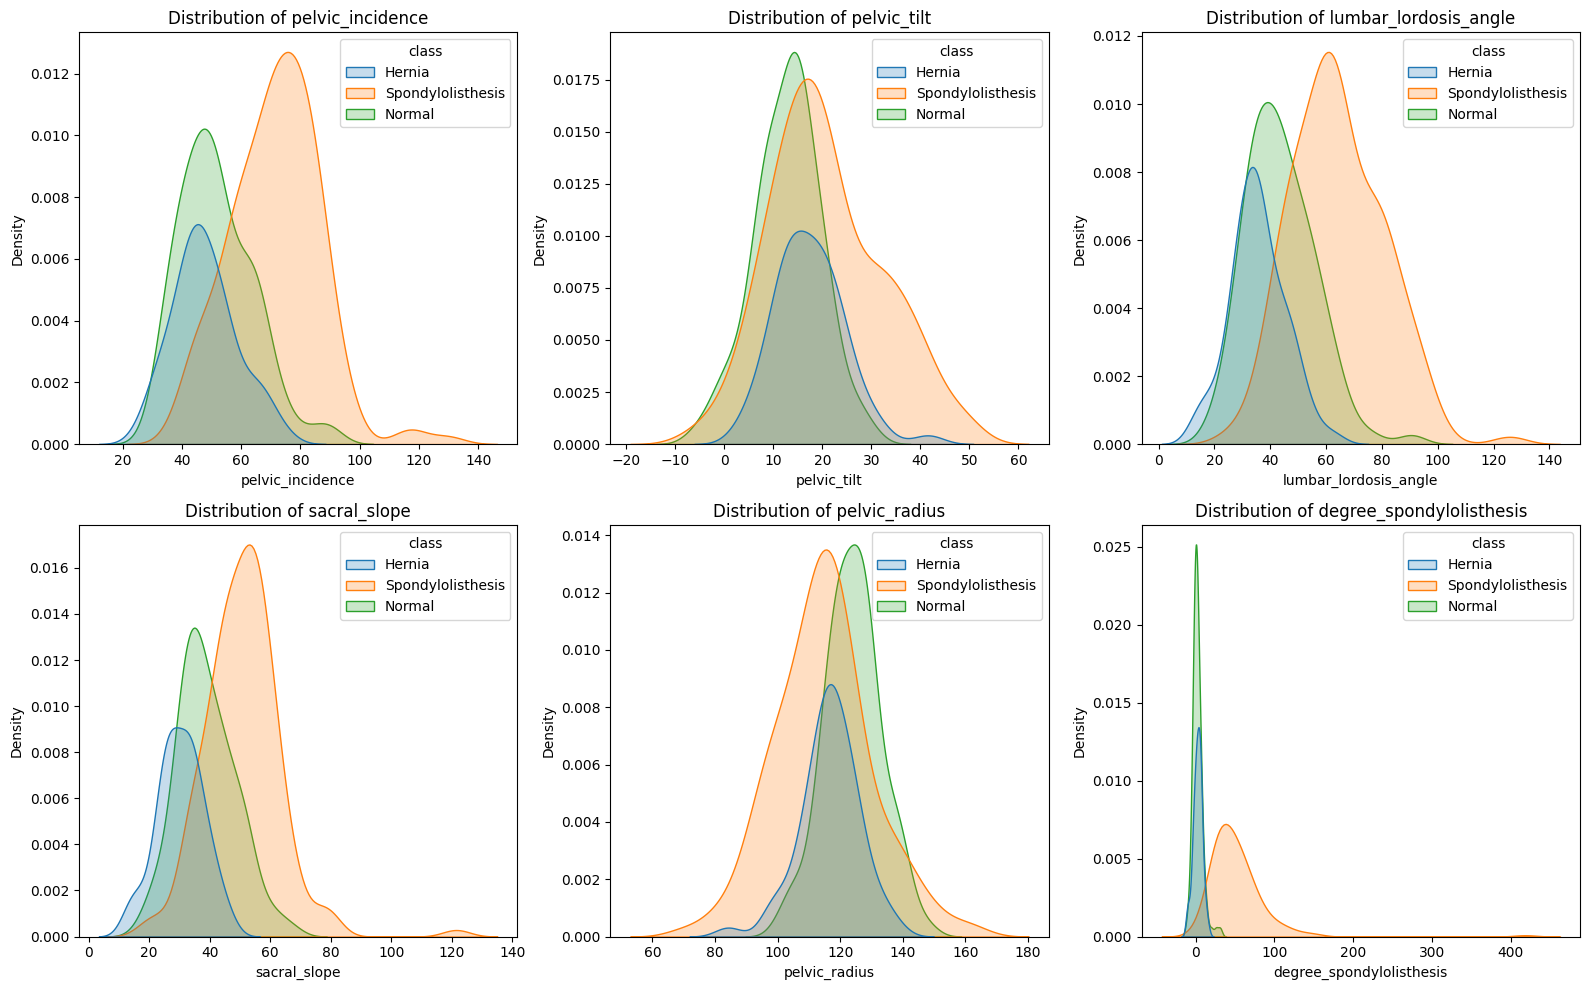

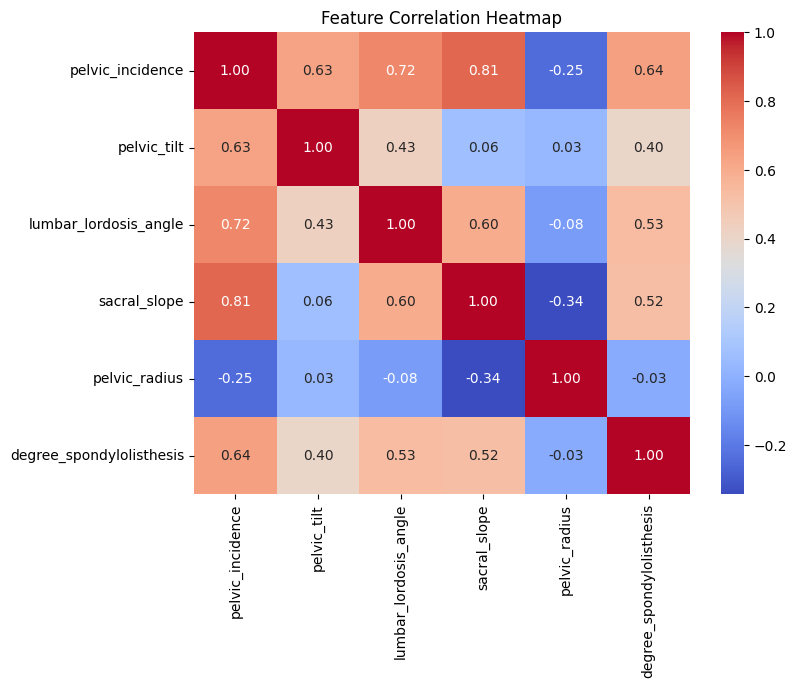

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rename class codes for readability
df['class'] = df['class'].map({'SL': 'Spondylolisthesis', 'NO': 'Normal', 'DH': 'Hernia'})

# --- 1. Feature Distributions ---
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=df, x=col, hue='class', fill=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# --- 2. Correlation Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop('class', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

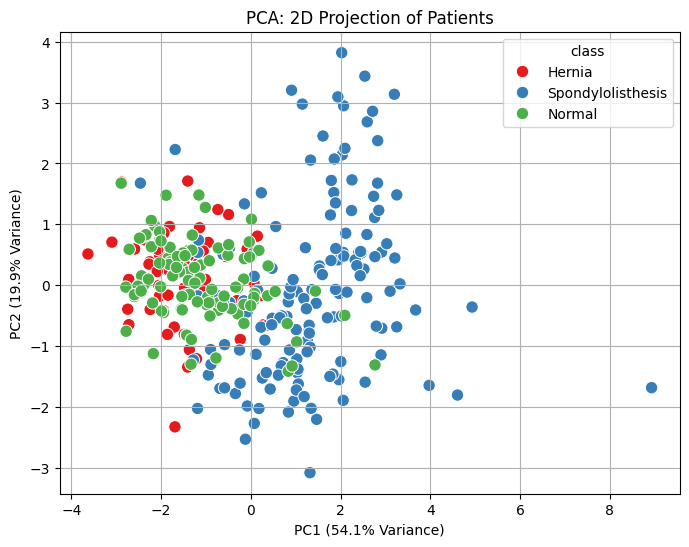

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate features and labels
X = df.drop("class", axis=1)
y = df["class"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine into a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["class"] = y.values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="class", palette="Set1", s=80)
plt.title("PCA: 2D Projection of Patients")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)")
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode class labels numerically
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # SL=2, NO=1, DH=0 (typically)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
}

# Evaluate using cross-validation
for name, model in models.items():
    acc = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="accuracy")
    f1 = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="f1_weighted")
    print(f"\n🔹 {name}")
    print(f"Accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"F1 Score: {f1.mean():.3f} ± {f1.std():.3f}")


🔹 Logistic Regression
Accuracy: 0.835 ± 0.066
F1 Score: 0.833 ± 0.069

🔹 Random Forest
Accuracy: 0.868 ± 0.049
F1 Score: 0.832 ± 0.059

🔹 SVM (RBF)
Accuracy: 0.839 ± 0.080
F1 Score: 0.836 ± 0.082


/var/folders/7r/m8v4tkn15jd4nfnjhb1n92280000gn/T/ipykernel_2235/697139329.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracy_scores.values(), labels=accuracy_scores.keys())


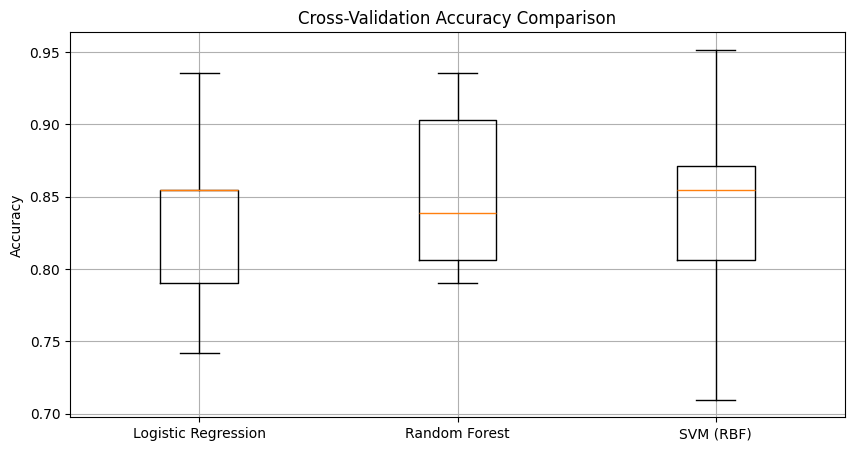

/var/folders/7r/m8v4tkn15jd4nfnjhb1n92280000gn/T/ipykernel_2235/697139329.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(f1_scores.values(), labels=f1_scores.keys())


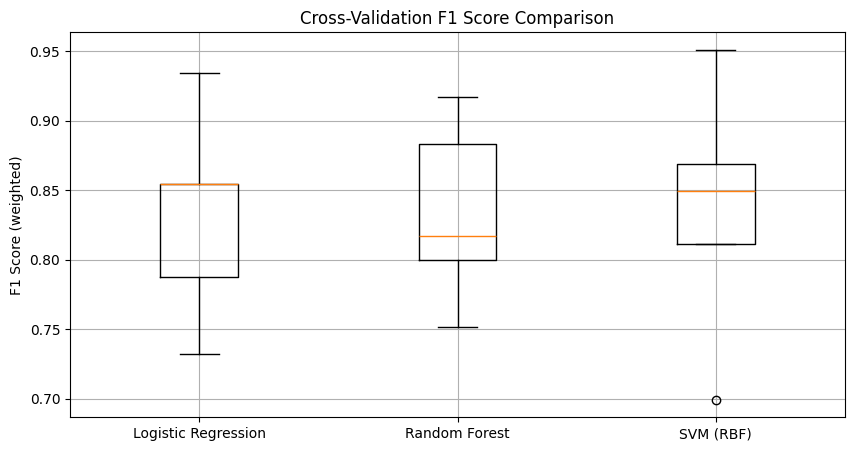

In [8]:
import matplotlib.pyplot as plt

# Store results for plotting
accuracy_scores = {}
f1_scores = {}

for name, model in models.items():
    acc = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="accuracy")
    f1 = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="f1_weighted")
    accuracy_scores[name] = acc
    f1_scores[name] = f1

# Boxplot for Accuracy
plt.figure(figsize=(10, 5))
plt.boxplot(accuracy_scores.values(), labels=accuracy_scores.keys())
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Boxplot for F1 Score
plt.figure(figsize=(10, 5))
plt.boxplot(f1_scores.values(), labels=f1_scores.keys())
plt.title("Cross-Validation F1 Score Comparison")
plt.ylabel("F1 Score (weighted)")
plt.grid(True)
plt.show()

In [9]:
model_results = {}

for name in models.keys():
    acc_mean = accuracy_scores[name].mean()
    acc_std = accuracy_scores[name].std()
    f1_mean = f1_scores[name].mean()
    f1_std = f1_scores[name].std()
    
    model_results[name] = {
        "accuracy_mean": round(acc_mean, 3),
        "accuracy_std": round(acc_std, 3),
        "f1_mean": round(f1_mean, 3),
        "f1_std": round(f1_std, 3),
    }

# Example output
import pprint
pprint.pprint(model_results)

{'Logistic Regression': {'accuracy_mean': np.float64(0.835),
                         'accuracy_std': np.float64(0.066),
                         'f1_mean': np.float64(0.833),
                         'f1_std': np.float64(0.069)},
 'Random Forest': {'accuracy_mean': np.float64(0.855),
                   'accuracy_std': np.float64(0.056),
                   'f1_mean': np.float64(0.834),
                   'f1_std': np.float64(0.059)},
 'SVM (RBF)': {'accuracy_mean': np.float64(0.839),
               'accuracy_std': np.float64(0.08),
               'f1_mean': np.float64(0.836),
               'f1_std': np.float64(0.082)}}


In [13]:
import shap

# Fit the Random Forest model if not already fitted
rf_model = models["Random Forest"]
rf_model.fit(X_scaled, y_encoded)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_scaled)

In [2]:
%pip uninstall numpy shap -y
%pip install numpy==2.0.0
%pip install shap

Found existing installation: numpy 2.1.0
Uninstalling numpy-2.1.0:
  Successfully uninstalled numpy-2.1.0
Found existing installation: shap 0.47.0
Uninstalling shap-0.47.0:
  Successfully uninstalled shap-0.47.0
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 144.8 kB/s eta 0:00:00a 0:00:02
Note: you may need to restart the kernel to use updated packages.
  Using cached shap-0.48.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached shap-0.48.0-cp312-cp312-macosx_11_0_arm64.whl (547 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
print(df.columns)

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')
